# Introduction / Business Problem

A friend wants to open a new fusion Indian restaurant in Toronto. He plans to make it slightly upscale, and wants to attract a diverse range of customers, rather than having a predominantly Indian customer base. He is confused about which neighborhood he should open his new restaurant in.

I have suggested that he use 3 criteria to pick the location.

1) His restaurant should be located in an upscale neighborhood, surrounded by similarly upscale stores and restaurants.

2) His restaurant should be located in a neighborhood that doesn't already have too many Indian restaurants. How many is too many? We will need restaurant data from Toronto to be sure. For now, I would like to have no other Indian restaurant within 500 metres of my friend's new restaurant.

3) His restaurant should be located in a neighborhood that already attracts a diverse crowd. E.g., a neighborhood that has multiple Italian, Korean, Mexican, etc. restaurants is better than a neighborhood dominated by, say, Korean restaurants.

My friend likes these 3 criteria and would like me to suggest locations that meet these 3 criteria. The rest of this project involves using Foursquare data to identify neighborhoods that meet these 3 criteria.

# Data

### First, some context

Before I describe the data, let me provide some context as to what I will do with the data.

I want to divide the neighborhoods of Toronto into 4 clusters based on how Upscale and Diverse they are. The 4 clusters will be:

(1) Both Upscale & Diverse

(2) Upscale, but not Diverse

(3) Diverse, but not Upscale

(4) Neither Upscale nor Diverse

Of these, I will focus just on the Upscale & Diverse neighborhoods for my final test. In this final test, I will rank the Upscale & Diverse neighborgoods by how many Indian restaurants they already have, and I will suggest that my friend pick one of the neighborhoods with fewer Indian restaurants.

### Next, an outline of the data

I am going to need the following data from Folium, Foursquare, and Wikipedia.

1) A map of Toronto to get started. This will come from Folium.

2) A basic dataset of boroughs and neighborhoods in Toronto, like the one I created for the Week 3 assignment of Segmenting and Clustering neighborhoods in Toronto. This will come from Wikipedia, just like in the Week 3 assignment.

3) Finally, for the K-means clustering, I will need data on the top venues in each neighborhood within a given radius. This will come from Foursquare, just like in the Week 3 assignment.

Overall, my approach will be similar to the analysis in Week 3 with just two major changes:

(1) I care only about the top restaurant venues, rather than all the top venues (i.e., I will be ignoring any venue that is not a restaurant).

(2) I need to define some metric that estimates the degree of diversity of restaurants, and the degree of upscale-ness of restaurants, for the K Means clustering.
    For measuring diversity, I will use the cuisine of each restaurant as raw data. I will get the cuisine from the 'Venue Category' field in Foursquare, which classified restaurants into "Afghan restaurant", "African restaurant", "American restaurant", etc. in the Week 3 Lab of segmenting neighborhoods in New York. The higher the variety in cuisine names, the higher that neighborhood's diversity score will be.
    For measuring upscale-ness, I will use the expensive-ness of each restaurant (using the 1-4 "dollar" scale) as raw data. I am looking for a neighborhood that is dominated by 2-dollar and 3-dollar restaurants, because 4-dollar will be too upscale, and 1-dollar will be too cheap.

### Finally, the code

#### Part 1: Scraping Data from Wikipedia to create a Pandas dataframe

Import libraries needed for data preparation

In [12]:
import requests
import pandas as pd

Get raw data from the Wikipedia page

In [13]:
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text

Import the Beautiful Soup package and format the HTML code behind the Wikipedia page

In [14]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,"lxml")
# print(soup.prettify())
# Executed the above line while testing code, but I have now commented it since it is a long, intermediate output that will make it harder to read my notebook.

Extract the table containing the data from the rest of the HTML code.

In [15]:
My_table = soup.find("table",{"class":"wikitable sortable"})

My_table

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Harbourfront_(Toronto)" title="Harbourfront (Toronto)">Harbourfront</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Regent Park</a>
</td></tr>
<tr>
<td>M6A</td>

Create a list in which every list element corresponds to one cell in the Wikipedia table.

E.g., the first 3 list elements will be "M1A", "Not assigned", and "Not assigned".

In [16]:
My_table_cells = My_table.findAll("td")

The ".text" part of each list element contains the data which we need for our Pandas dataframe.

Run the below code snippet to see how this works.

In [17]:
print("List elements of My_table_cells look like this:\n")
print(My_table_cells[6])
print(My_table_cells[7])
print(My_table_cells[8])
print("\n")

print("Using the .text function, we can extract the text we need:\n")
print(My_table_cells[6].text)
print(My_table_cells[7].text)
print(My_table_cells[8].text)
print("\n")

List elements of My_table_cells look like this:

<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td>


Using the .text function, we can extract the text we need:

M3A
North York
Parkwoods





Create a new list that contains only the text we are interested in (without the "td" parts).

The rstrip() function was used to remove the trailing "\n" that was a part of some list elements.

In [18]:
My_table_cells_text = []
num_entries = len(My_table_cells)
for i in range(0, num_entries):
    My_table_cells_text.append(My_table_cells[i].text.rstrip())

My_table_cells_text

['M1A',
 'Not assigned',
 'Not assigned',
 'M2A',
 'Not assigned',
 'Not assigned',
 'M3A',
 'North York',
 'Parkwoods',
 'M4A',
 'North York',
 'Victoria Village',
 'M5A',
 'Downtown Toronto',
 'Harbourfront',
 'M5A',
 'Downtown Toronto',
 'Regent Park',
 'M6A',
 'North York',
 'Lawrence Heights',
 'M6A',
 'North York',
 'Lawrence Manor',
 'M7A',
 "Queen's Park",
 'Not assigned',
 'M8A',
 'Not assigned',
 'Not assigned',
 'M9A',
 'Etobicoke',
 'Islington Avenue',
 'M1B',
 'Scarborough',
 'Rouge',
 'M1B',
 'Scarborough',
 'Malvern',
 'M2B',
 'Not assigned',
 'Not assigned',
 'M3B',
 'North York',
 'Don Mills North',
 'M4B',
 'East York',
 'Woodbine Gardens',
 'M4B',
 'East York',
 'Parkview Hill',
 'M5B',
 'Downtown Toronto',
 'Ryerson',
 'M5B',
 'Downtown Toronto',
 'Garden District',
 'M6B',
 'North York',
 'Glencairn',
 'M7B',
 'Not assigned',
 'Not assigned',
 'M8B',
 'Not assigned',
 'Not assigned',
 'M9B',
 'Etobicoke',
 'Cloverdale',
 'M9B',
 'Etobicoke',
 'Islington',
 'M9B',
 

Create an empty Pandas dataframe to populate the Wikipedia data

In [19]:
df = pd.DataFrame(columns = ["PostalCode", "Borough", "Neighborhood"])
df.head()

,PostalCode,Borough,Neighborhood


Create 3 new lists from the My_table_cells_text list - One list for postal codes, one for boroughs, and one for neighborhoods.

We will use these 3 separate lists to populate the Pandas dataframe columns.

Postal codes are present in list elements 0,3,6,9,12,15, and so on.

In [20]:
My_postcodes = []
for i in range(0, len(My_table_cells_text),3):
    My_postcodes.append(My_table_cells_text[i])

My_postcodes

['M1A',
 'M2A',
 'M3A',
 'M4A',
 'M5A',
 'M5A',
 'M6A',
 'M6A',
 'M7A',
 'M8A',
 'M9A',
 'M1B',
 'M1B',
 'M2B',
 'M3B',
 'M4B',
 'M4B',
 'M5B',
 'M5B',
 'M6B',
 'M7B',
 'M8B',
 'M9B',
 'M9B',
 'M9B',
 'M9B',
 'M9B',
 'M1C',
 'M1C',
 'M1C',
 'M2C',
 'M3C',
 'M3C',
 'M4C',
 'M5C',
 'M6C',
 'M7C',
 'M8C',
 'M9C',
 'M9C',
 'M9C',
 'M9C',
 'M1E',
 'M1E',
 'M1E',
 'M2E',
 'M3E',
 'M4E',
 'M5E',
 'M6E',
 'M7E',
 'M8E',
 'M9E',
 'M1G',
 'M2G',
 'M3G',
 'M4G',
 'M5G',
 'M6G',
 'M7G',
 'M8G',
 'M9G',
 'M1H',
 'M2H',
 'M3H',
 'M3H',
 'M3H',
 'M4H',
 'M5H',
 'M5H',
 'M5H',
 'M6H',
 'M6H',
 'M7H',
 'M8H',
 'M9H',
 'M1J',
 'M2J',
 'M2J',
 'M2J',
 'M3J',
 'M3J',
 'M4J',
 'M5J',
 'M5J',
 'M5J',
 'M6J',
 'M6J',
 'M7J',
 'M8J',
 'M9J',
 'M1K',
 'M1K',
 'M1K',
 'M2K',
 'M3K',
 'M3K',
 'M4K',
 'M4K',
 'M5K',
 'M5K',
 'M6K',
 'M6K',
 'M6K',
 'M7K',
 'M8K',
 'M9K',
 'M1L',
 'M1L',
 'M1L',
 'M2L',
 'M2L',
 'M3L',
 'M4L',
 'M4L',
 'M5L',
 'M5L',
 'M6L',
 'M6L',
 'M6L',
 'M7L',
 'M8L',
 'M9L',
 'M1M',
 'M1M',


Boroughs are present in list elements 1,4,7,10, and so on.

In [21]:
My_boroughs = []
for i in range(1, len(My_table_cells_text),3):
    My_boroughs.append(My_table_cells_text[i])

My_boroughs

['Not assigned',
 'Not assigned',
 'North York',
 'North York',
 'Downtown Toronto',
 'Downtown Toronto',
 'North York',
 'North York',
 "Queen's Park",
 'Not assigned',
 'Etobicoke',
 'Scarborough',
 'Scarborough',
 'Not assigned',
 'North York',
 'East York',
 'East York',
 'Downtown Toronto',
 'Downtown Toronto',
 'North York',
 'Not assigned',
 'Not assigned',
 'Etobicoke',
 'Etobicoke',
 'Etobicoke',
 'Etobicoke',
 'Etobicoke',
 'Scarborough',
 'Scarborough',
 'Scarborough',
 'Not assigned',
 'North York',
 'North York',
 'East York',
 'Downtown Toronto',
 'York',
 'Not assigned',
 'Not assigned',
 'Etobicoke',
 'Etobicoke',
 'Etobicoke',
 'Etobicoke',
 'Scarborough',
 'Scarborough',
 'Scarborough',
 'Not assigned',
 'Not assigned',
 'East Toronto',
 'Downtown Toronto',
 'York',
 'Not assigned',
 'Not assigned',
 'Not assigned',
 'Scarborough',
 'Not assigned',
 'Not assigned',
 'East York',
 'Downtown Toronto',
 'Downtown Toronto',
 'Not assigned',
 'Not assigned',
 'Not assigned

Neighborhoods are present in list elements 2,5,8,11, and so on.

In [22]:
My_neighborhoods = []
for i in range(2, len(My_table_cells_text),3):
    My_neighborhoods.append(My_table_cells_text[i])

My_neighborhoods

['Not assigned',
 'Not assigned',
 'Parkwoods',
 'Victoria Village',
 'Harbourfront',
 'Regent Park',
 'Lawrence Heights',
 'Lawrence Manor',
 'Not assigned',
 'Not assigned',
 'Islington Avenue',
 'Rouge',
 'Malvern',
 'Not assigned',
 'Don Mills North',
 'Woodbine Gardens',
 'Parkview Hill',
 'Ryerson',
 'Garden District',
 'Glencairn',
 'Not assigned',
 'Not assigned',
 'Cloverdale',
 'Islington',
 'Martin Grove',
 'Princess Gardens',
 'West Deane Park',
 'Highland Creek',
 'Rouge Hill',
 'Port Union',
 'Not assigned',
 'Flemingdon Park',
 'Don Mills South',
 'Woodbine Heights',
 'St. James Town',
 'Humewood-Cedarvale',
 'Not assigned',
 'Not assigned',
 'Bloordale Gardens',
 'Eringate',
 'Markland Wood',
 'Old Burnhamthorpe',
 'Guildwood',
 'Morningside',
 'West Hill',
 'Not assigned',
 'Not assigned',
 'The Beaches',
 'Berczy Park',
 'Caledonia-Fairbanks',
 'Not assigned',
 'Not assigned',
 'Not assigned',
 'Woburn',
 'Not assigned',
 'Not assigned',
 'Leaside',
 'Central Bay Stre

Populate the Pandas dataframe with data from the 3 lists we just created.

In [23]:
df["PostalCode"] = My_postcodes
df["Borough"] = My_boroughs
df["Neighborhood"] = My_neighborhoods
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


Check how big the dataframe is

In [24]:
df.shape

(288, 3)

Drop rows where the Borough is "Not assigned"

In [25]:
df.drop(df[df["Borough"] == "Not assigned"].index, inplace=True)
df.head(10)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


Check the size of the dataframe after dropping rows where Borough = "Not assigned"

In [26]:
df.shape

(211, 3)

Check how many Neighborhoods are "Not assigned"

In [27]:
df.loc[df["Neighborhood"] == "Not assigned", "Neighborhood"]

8    Not assigned
Name: Neighborhood, dtype: object

Only 1 neighborhood is "not assigned"; replace the "not assigned" with the name of the Borough.

In [28]:
df.loc[df["Neighborhood"] == "Not assigned", "Neighborhood"] = df.loc[df["Neighborhood"] == "Not assigned", "Borough"]

Group the data by PostalCode

In [29]:
grouped_df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(",".join).reset_index()

View the size of the final dataframe

In [30]:
grouped_df.shape

(103, 3)

View the final dataframe

In [31]:
grouped_df

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


#### Part 2: Getting Latitude & Longitude

I tried using Geocoder but it did not work for me. The code I used below gets Latitude and Longitude data from the csv file shared in the assignment.

In [32]:
LatLong = pd.read_csv("http://cocl.us/Geospatial_data")

Check the columns and number of rows to verify that the data was imported correctly.

In [33]:
LatLong.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [34]:
LatLong.shape

(103, 3)

In [35]:
LatLong.rename(columns = {"Postal Code": "PostalCode"}, inplace=True)
LatLong.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [36]:
final_df = pd.merge(grouped_df, LatLong, how="left", on="PostalCode")

Check the number of rows.

In [37]:
final_df.shape

(103, 5)

Check the final dataframe

In [38]:
final_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


#### Part 3: Clustering the Neighborhoods

Import all the required libraries.

In [39]:
import pandas as pd
import numpy as np
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print("Libraries imported.")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

Create a new dataframe with just the Boroughs that have "Toronto" in their name.

In [40]:
df_toronto = final_df[final_df.Borough.str.contains("Toronto", case=False)]
df_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049


Reset the index to start from index=0

In [41]:
df_toronto.reset_index(drop=True)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049


Create a map of Toronto

In [42]:
# create map of Toronto using latitude and longitude values
toronto_latitude = 43.6532
toronto_longitude = -79.3832

map_toronto = folium.Map(location=[toronto_latitude,toronto_longitude], zoom_start=10)

map_toronto

Add markers to the map

In [43]:
# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Define Foursquare credentials and version.

In [44]:
CLIENT_ID = 'NTW3XHHVYEC4SGLFRPEVZJ5343WGXACTO0TDTD4EQFHIMVHV' # your Foursquare ID
CLIENT_SECRET = 'CFBXH3TV0WM1JBBFYXD0TG2LJ2GTWJBHFTLRSVO0S5UIGKA5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NTW3XHHVYEC4SGLFRPEVZJ5343WGXACTO0TDTD4EQFHIMVHV
CLIENT_SECRET:CFBXH3TV0WM1JBBFYXD0TG2LJ2GTWJBHFTLRSVO0S5UIGKA5


Define function to get nearby venues for each neighborhood.

In [45]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue_ID']
    
    return(nearby_venues)

Get nearby venues for the Toronto neighborhoods.

In [46]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvall

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue_ID
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail,4bd461bc77b29c74a07d9282
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,4ad4c062f964a52011f820e3
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub,4b8daea1f964a520480833e3
3,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park,4dbc8fe96a23e294ba3237bd
4,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors,56afcad6498e05333bf42031


In [47]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 uniques categories.


In [48]:
print('There are {} uniques venue IDs.'.format(len(toronto_venues['Venue_ID'].unique())))

There are 1230 uniques venue IDs.


Filtering the venues that are restaurants.

In [49]:
toronto_restaurants = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")]
print(toronto_restaurants.shape)
toronto_restaurants.head(25)

(405, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue_ID
6,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,4bce4183ef10952197da8386
8,"The Danforth West,Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant,4e3dbb5e45dd68e3273e03b7
10,"The Danforth West,Riverdale",43.679557,-79.352188,Mezes,43.677962,-79.350196,Greek Restaurant,4afdfadff964a520a52c22e3
11,"The Danforth West,Riverdale",43.679557,-79.352188,Messini Authentic Gyros,43.677827,-79.350569,Greek Restaurant,4aeb268bf964a52006bf21e3
15,"The Danforth West,Riverdale",43.679557,-79.352188,7 Numbers,43.677062,-79.353934,Italian Restaurant,4af4e0d0f964a5202ff721e3
18,"The Danforth West,Riverdale",43.679557,-79.352188,Alexandros,43.678304,-79.349486,Greek Restaurant,4ae29e2af964a520338f21e3
22,"The Danforth West,Riverdale",43.679557,-79.352188,Rikkochez,43.677267,-79.353274,Restaurant,5916090a69e77b035ceb1a86
26,"The Danforth West,Riverdale",43.679557,-79.352188,Athen's Pastries,43.678166,-79.348927,Greek Restaurant,4bbe3c929474c9b6d54cd9b6
29,"The Danforth West,Riverdale",43.679557,-79.352188,Christina's On The Danforth,43.678240,-79.349185,Greek Restaurant,4b64ce4af964a52084d12ae3
30,"The Danforth West,Riverdale",43.679557,-79.352188,Pan on the Danforth,43.678263,-79.348648,Greek Restaurant,4b396a9ef964a520495c25e3


Next, let us try to measure the diversity of cuisines available in each neighborhood, and also the competition from neighboring Indian restaurants. For this, I will prepare a data set containing just 4 columns: Neighborhood name, Total number of restaurants in the neighborhood, Total number of cuisines available in the neighborhood, Total number of Indian restaurants in the neighborhood.

In [50]:
restaurants = toronto_restaurants[['Neighborhood', 'Venue', 'Venue Category']]
restaurants = restaurants.rename(columns = {'Venue Category':'Venue_Category'})
restaurants.head()

,Neighborhood,Venue,Venue_Category
6,"The Danforth West,Riverdale",Pantheon,Greek Restaurant
8,"The Danforth West,Riverdale",Cafe Fiorentina,Italian Restaurant
10,"The Danforth West,Riverdale",Mezes,Greek Restaurant
11,"The Danforth West,Riverdale",Messini Authentic Gyros,Greek Restaurant
15,"The Danforth West,Riverdale",7 Numbers,Italian Restaurant


In [51]:
total_restaurants = restaurants.groupby('Neighborhood').Venue.nunique().to_frame()
total_restaurants = total_restaurants.rename(columns = {'Venue':'Total_Restaurants'})
total_restaurants.head()

,Total_Restaurants
Neighborhood,
"Adelaide,King,Richmond",29
Berczy Park,11
"Brockton,Exhibition Place,Parkdale Village",3
Business Reply Mail Processing Centre 969 Eastern,2
"Cabbagetown,St. James Town",12


In [52]:
restaurants.loc[restaurants['Neighborhood']=='Studio District']

,Neighborhood,Venue,Venue_Category
76,Studio District,Reliable Halibut and Chips,Seafood Restaurant
78,Studio District,Tabule,Middle Eastern Restaurant
79,Studio District,EAT BKK Thai Kitchen,Thai Restaurant
80,Studio District,Baldini,Italian Restaurant
83,Studio District,eastside social,Comfort Food Restaurant
87,Studio District,braised,American Restaurant
88,Studio District,Lil' Baci,Italian Restaurant
93,Studio District,Barrio Cerveceria,Latin American Restaurant
96,Studio District,Brooklyn Tavern,American Restaurant


In [53]:
unique_cuisines = restaurants.groupby('Neighborhood').Venue_Category.nunique().to_frame()
unique_cuisines = unique_cuisines.rename(columns = {'Venue_Category':'Unique_Cuisines'})
unique_cuisines.head()

,Unique_Cuisines
Neighborhood,
"Adelaide,King,Richmond",18
Berczy Park,10
"Brockton,Exhibition Place,Parkdale Village",3
Business Reply Mail Processing Centre 969 Eastern,2
"Cabbagetown,St. James Town",9


In [54]:
indian_restaurants = restaurants[restaurants['Venue_Category'].str.contains("India")]
indian_restaurants

,Neighborhood,Venue,Venue_Category
34,"The Danforth West,Riverdale",Sher-E-Punjab,Indian Restaurant
138,Davisville,Marigold Indian Bistro,Indian Restaurant
189,"Cabbagetown,St. James Town",Butter Chicken Factory,Indian Restaurant
259,Church and Wellesley,Kothur Indian Cuisine,Indian Restaurant
536,St. James Town,Bombay Palace,Indian Restaurant
616,Berczy Park,Bindia Indian Bistro,Indian Restaurant
688,Central Bay Street,Colaba Junction,Indian Restaurant
790,"Adelaide,King,Richmond",Little India Restaurant,Indian Restaurant
868,"Harbourfront East,Toronto Islands,Union Station",Indian Roti House,Indian Restaurant
1110,"The Annex,North Midtown,Yorkville",Roti Cuisine of India,Indian Restaurant


In [55]:
indian_restaurants = indian_restaurants.groupby('Neighborhood').Venue.nunique().to_frame()
indian_restaurants = indian_restaurants.rename(columns = {'Venue':'Number_of_Indian_Restaurants'})
indian_restaurants

,Number_of_Indian_Restaurants
Neighborhood,
"Adelaide,King,Richmond",1
Berczy Park,1
"Cabbagetown,St. James Town",1
Central Bay Street,1
Church and Wellesley,1
Davisville,1
"Harbourfront East,Toronto Islands,Union Station",1
St. James Town,1
Stn A PO Boxes 25 The Esplanade,1


In [56]:
restaurants_diversity = pd.merge(total_restaurants, unique_cuisines, how='left', on=['Neighborhood'])
restaurants_diversity = pd.merge(restaurants_diversity, indian_restaurants, how='left', on=['Neighborhood'])
restaurants_diversity['Number_of_Indian_Restaurants'] = restaurants_diversity['Number_of_Indian_Restaurants'].replace(np.nan,0)
restaurants_diversity.head()

,Total_Restaurants,Unique_Cuisines,Number_of_Indian_Restaurants
Neighborhood,,,
"Adelaide,King,Richmond",29,18,1.0
Berczy Park,11,10,1.0
"Brockton,Exhibition Place,Parkdale Village",3,3,0.0
Business Reply Mail Processing Centre 969 Eastern,2,2,0.0
"Cabbagetown,St. James Town",12,9,1.0


We now have the raw data in a processed form to evaluate neighborhoods on their diversity. We next need to get data on restaurant prices in each neighborhood.

### Rest of the K Means clustering code is yet to be written.

Figuring out which part of the GET request has restaurant priciness data.

In [57]:
venue_id_series = toronto_restaurants['Venue_ID']
venue_id_list = venue_id_series.tolist()

venue_id_list

['4bce4183ef10952197da8386',
 '4e3dbb5e45dd68e3273e03b7',
 '4afdfadff964a520a52c22e3',
 '4aeb268bf964a52006bf21e3',
 '4af4e0d0f964a5202ff721e3',
 '4ae29e2af964a520338f21e3',
 '5916090a69e77b035ceb1a86',
 '4bbe3c929474c9b6d54cd9b6',
 '4b64ce4af964a52084d12ae3',
 '4b396a9ef964a520495c25e3',
 '4ad4c05ff964a52042f720e3',
 '4c1d5337eac020a1cb1048c2',
 '5269ba3c498ea63de3eb987b',
 '4afc9333f964a5200c2422e3',
 '4af6e7a0f964a520060422e3',
 '4d28fa67ebacb1f7f37ff64f',
 '4ba0153bf964a520995837e3',
 '4fd52f42e4b0b916eb02ab1b',
 '4b1b0a31f964a520ebf623e3',
 '4afef85ff964a5204a3222e3',
 '519d414a498e6cc21f677ff4',
 '5ba55b9ae0c0c9002c29d056',
 '4b1169f6f964a520177c23e3',
 '53aa1f88498e13bffd98b62e',
 '53c4629f498ef9114ca25be3',
 '4ad8b99df964a5200b1421e3',
 '57812342cd10afc6f76161db',
 '529921fa11d2ec80b7868277',
 '4aec79e5f964a5209fc721e3',
 '5738efd3498ef5d2444c477e',
 '515f21e5e4b03c1e772c36c7',
 '5169d445e4b07de190b5c3d6',
 '4b939d18f964a520454a34e3',
 '4bd4b2546798ef3bb235628d',
 '4b258fcef964

In [58]:
len(venue_id_list)

405

In [59]:
# The below code should be correct for getting price tiers of all the restaurants, but wait for
# 1) figuring out how to save the output in a local csv file
# 2) Debugging the code thoroughly
# So that you don't waste your limited premium API calls that are left.

dict_for_df = []

for venue_id in venue_id_list:
    url2 = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    result = requests.get(url2).json()
    name_flag = result['response']['venue'].get('name')
    if(name_flag):
        name = result['response']['venue']['name']
    else:
        name = 'Name unknown'
    price_flag = result['response']['venue'].get('price')
    if(price_flag):
        price_tier = result['response']['venue']['price']['tier']
    else:
        price_tier = 0
    dict_for_df.append({'Venue_ID' : venue_id, 'Name' : name, 'Price_Tier' : price_tier})

Safeguarding above for loop for errors in case price information is not available.

In [90]:
'''

venue_id_list_test = ["4bd461bc77b29c74a07d9282", "4bce4183ef10952197da8386", "4df91c4bae60f95f82229ad5"]
dict_for_df_test = []

for venue_id in venue_id_list_test:
    url2 = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    result = requests.get(url2).json()
    name_flag = result['response']['venue'].get('name')
    if(name_flag):
        name = result['response']['venue']['name']
    else:
        name = 'Name unknown'
    price_flag = result['response']['venue'].get('price')
    if(price_flag):
        price_tier = result['response']['venue']['price']['tier']
    else:
        price_tier = 0
    dict_for_df_test.append({'Venue_ID' : venue_id, 'Name' : name, 'Price_Tier' : price_tier})

'''

In [60]:
dict_for_df

[{'Venue_ID': '4bce4183ef10952197da8386', 'Name': 'Pantheon', 'Price_Tier': 2},
 {'Venue_ID': '4e3dbb5e45dd68e3273e03b7',
  'Name': 'Cafe Fiorentina',
  'Price_Tier': 2},
 {'Venue_ID': '4afdfadff964a520a52c22e3', 'Name': 'Mezes', 'Price_Tier': 2},
 {'Venue_ID': '4aeb268bf964a52006bf21e3',
  'Name': 'Messini Authentic Gyros',
  'Price_Tier': 1},
 {'Venue_ID': '4af4e0d0f964a5202ff721e3',
  'Name': '7 Numbers',
  'Price_Tier': 2},
 {'Venue_ID': '4ae29e2af964a520338f21e3',
  'Name': 'Alexandros',
  'Price_Tier': 1},
 {'Venue_ID': '5916090a69e77b035ceb1a86',
  'Name': 'Rikkochez',
  'Price_Tier': 2},
 {'Venue_ID': '4bbe3c929474c9b6d54cd9b6',
  'Name': "Athen's Pastries",
  'Price_Tier': 2},
 {'Venue_ID': '4b64ce4af964a52084d12ae3',
  'Name': "Christina's On The Danforth",
  'Price_Tier': 2},
 {'Venue_ID': '4b396a9ef964a520495c25e3',
  'Name': 'Pan on the Danforth',
  'Price_Tier': 3},
 {'Venue_ID': '4ad4c05ff964a52042f720e3',
  'Name': 'Astoria Shish Kebob House',
  'Price_Tier': 2},
 {'Ven

In [74]:
df_price = pd.DataFrame(dict_for_df)

In [77]:
df_price.drop_duplicates(keep='first', inplace=True)

In [78]:
df_price

,Name,Price_Tier,Venue_ID
0,Pantheon,2,4bce4183ef10952197da8386
1,Cafe Fiorentina,2,4e3dbb5e45dd68e3273e03b7
2,Mezes,2,4afdfadff964a520a52c22e3
3,Messini Authentic Gyros,1,4aeb268bf964a52006bf21e3
4,7 Numbers,2,4af4e0d0f964a5202ff721e3
5,Alexandros,1,4ae29e2af964a520338f21e3
6,Rikkochez,2,5916090a69e77b035ceb1a86
7,Athen's Pastries,2,4bbe3c929474c9b6d54cd9b6
8,Christina's On The Danforth,2,4b64ce4af964a52084d12ae3
9,Pan on the Danforth,3,4b396a9ef964a520495c25e3


Saving the data to a local CSV for future use, since price data came from a premium Foursquare endpoint that I cannot reuse multiple times.

In [67]:
import base64  
import pandas as pd

from IPython.display import HTML

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df_price)

In [80]:
restaurants_price_tiers = pd.merge(toronto_restaurants, df_price, how='left', on=['Venue_ID'])
restaurants_price_tiers

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue_ID,Name,Price_Tier
0,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,4bce4183ef10952197da8386,Pantheon,2
1,"The Danforth West,Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant,4e3dbb5e45dd68e3273e03b7,Cafe Fiorentina,2
2,"The Danforth West,Riverdale",43.679557,-79.352188,Mezes,43.677962,-79.350196,Greek Restaurant,4afdfadff964a520a52c22e3,Mezes,2
3,"The Danforth West,Riverdale",43.679557,-79.352188,Messini Authentic Gyros,43.677827,-79.350569,Greek Restaurant,4aeb268bf964a52006bf21e3,Messini Authentic Gyros,1
4,"The Danforth West,Riverdale",43.679557,-79.352188,7 Numbers,43.677062,-79.353934,Italian Restaurant,4af4e0d0f964a5202ff721e3,7 Numbers,2
5,"The Danforth West,Riverdale",43.679557,-79.352188,Alexandros,43.678304,-79.349486,Greek Restaurant,4ae29e2af964a520338f21e3,Alexandros,1
6,"The Danforth West,Riverdale",43.679557,-79.352188,Rikkochez,43.677267,-79.353274,Restaurant,5916090a69e77b035ceb1a86,Rikkochez,2
7,"The Danforth West,Riverdale",43.679557,-79.352188,Athen's Pastries,43.678166,-79.348927,Greek Restaurant,4bbe3c929474c9b6d54cd9b6,Athen's Pastries,2
8,"The Danforth West,Riverdale",43.679557,-79.352188,Christina's On The Danforth,43.678240,-79.349185,Greek Restaurant,4b64ce4af964a52084d12ae3,Christina's On The Danforth,2
9,"The Danforth West,Riverdale",43.679557,-79.352188,Pan on the Danforth,43.678263,-79.348648,Greek Restaurant,4b396a9ef964a520495c25e3,Pan on the Danforth,3


In [69]:
# create_download_link(toronto_restaurants)

In [70]:
# create_download_link(restaurants_price_tiers)

In [79]:
# create_download_link(df_price)

In [85]:
neighborhood_upscale_levels = restaurants_price_tiers.groupby('Neighborhood')['Price_Tier'].mean().to_frame()

In [86]:
neighborhood_upscale_levels

,Price_Tier
Neighborhood,
"Adelaide,King,Richmond",2.482759
Berczy Park,1.909091
"Brockton,Exhibition Place,Parkdale Village",2.000000
Business Reply Mail Processing Centre 969 Eastern,1.500000
"Cabbagetown,St. James Town",1.666667
Central Bay Street,1.904762
"Chinatown,Grange Park,Kensington Market",1.466667
Christie,2.000000
Church and Wellesley,1.758621


In [87]:
toronto_neighborhoods_summary = pd.merge(restaurants_diversity, neighborhood_upscale_levels, how='left', on='Neighborhood')

In [88]:
toronto_neighborhoods_summary

,Total_Restaurants,Unique_Cuisines,Number_of_Indian_Restaurants,Price_Tier
Neighborhood,,,,
"Adelaide,King,Richmond",29,18,1.0,2.482759
Berczy Park,11,10,1.0,1.909091
"Brockton,Exhibition Place,Parkdale Village",3,3,0.0,2.000000
Business Reply Mail Processing Centre 969 Eastern,2,2,0.0,1.500000
"Cabbagetown,St. James Town",12,9,1.0,1.666667
Central Bay Street,21,16,1.0,1.904762
"Chinatown,Grange Park,Kensington Market",30,15,0.0,1.466667
Christie,2,2,0.0,2.000000
Church and Wellesley,29,18,1.0,1.758621


In [95]:
create_download_link(toronto_neighborhoods_summary)

Run K Means Clustering Algorithm

In [98]:
kclusters = 4

toronto_neighborhoods_clustering = toronto_neighborhoods_summary

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_neighborhoods_clustering)

kmeans.labels_[0:10] 

array([3, 0, 2, 2, 0, 1, 3, 2, 3, 1], dtype=int32)

In [99]:
kmeans.labels_

array([3, 0, 2, 2, 0, 1, 3, 2, 3, 1, 0, 2, 1, 2, 1, 2, 0, 0, 2, 2, 1, 2,
       2, 0, 1, 3, 1, 0, 2, 2, 0], dtype=int32)

In [103]:
toronto_neighborhoods_clustering.insert(4, 'Cluster_Labels', kmeans.labels_)
toronto_neighborhoods_clustering

,Total_Restaurants,Unique_Cuisines,Number_of_Indian_Restaurants,Price_Tier,Cluster_Labels,Cluster Labels
Neighborhood,,,,,,
"Adelaide,King,Richmond",29,18,1.0,2.482759,3,3
Berczy Park,11,10,1.0,1.909091,0,0
"Brockton,Exhibition Place,Parkdale Village",3,3,0.0,2.000000,2,2
Business Reply Mail Processing Centre 969 Eastern,2,2,0.0,1.500000,2,2
"Cabbagetown,St. James Town",12,9,1.0,1.666667,0,0
Central Bay Street,21,16,1.0,1.904762,1,1
"Chinatown,Grange Park,Kensington Market",30,15,0.0,1.466667,3,3
Christie,2,2,0.0,2.000000,2,2
Church and Wellesley,29,18,1.0,1.758621,3,3


In [106]:
toronto_neighborhoods_clustering.drop('Cluster Labels', axis=1)

,Total_Restaurants,Unique_Cuisines,Number_of_Indian_Restaurants,Price_Tier,Cluster_Labels
Neighborhood,,,,,
"Adelaide,King,Richmond",29,18,1.0,2.482759,3
Berczy Park,11,10,1.0,1.909091,0
"Brockton,Exhibition Place,Parkdale Village",3,3,0.0,2.000000,2
Business Reply Mail Processing Centre 969 Eastern,2,2,0.0,1.500000,2
"Cabbagetown,St. James Town",12,9,1.0,1.666667,0
Central Bay Street,21,16,1.0,1.904762,1
"Chinatown,Grange Park,Kensington Market",30,15,0.0,1.466667,3
Christie,2,2,0.0,2.000000,2
Church and Wellesley,29,18,1.0,1.758621,3


In [101]:
create_download_link(toronto_neighborhoods_clustering)

In [132]:
toronto_pivot = pd.pivot_table(toronto_neighborhoods_clustering, values = ['Total_Restaurants', 'Unique_Cuisines', 'Number_of_Indian_Restaurants', 'Price_Tier'], index = 'Cluster_Labels', 
                          aggfunc = np.average) 

# columns = 'Cluster_Labels',

toronto_pivot

,Number_of_Indian_Restaurants,Price_Tier,Total_Restaurants,Unique_Cuisines
Cluster_Labels,,,,
0,0.625000,1.995779,11.250000,7.875000
1,0.285714,2.224057,22.428571,14.285714
2,0.083333,1.951389,3.333333,3.000000
3,0.750000,2.013550,28.500000,16.750000


In [122]:
import matplotlib.pyplot as plt

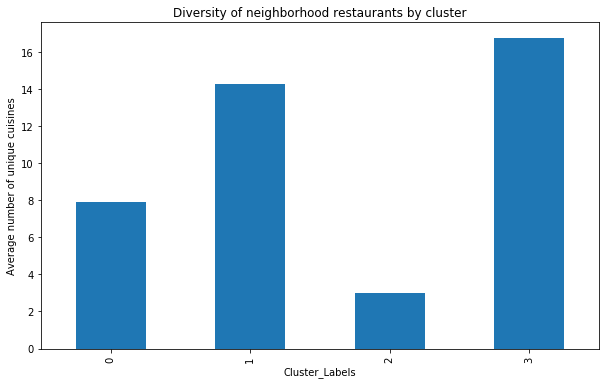

In [128]:
df_unique_cuisines = toronto_pivot.loc[(0,1,2,3), 'Unique_Cuisines']
df_unique_cuisines.plot(kind='bar', figsize=(10,6))
plt.ylabel('Average number of unique cuisines') # add y-label to the plot
plt.title('Diversity of neighborhood restaurants by cluster') # add title to the plot
plt.show()

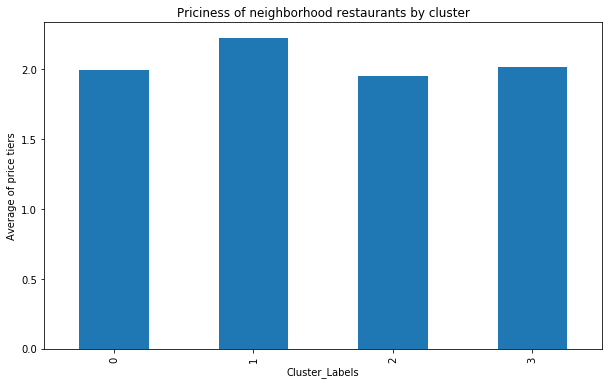

In [129]:
df_price_tiers = toronto_pivot.loc[(0,1,2,3), 'Price_Tier']
df_price_tiers.plot(kind='bar', figsize=(10,6))
plt.ylabel('Average of price tiers') # add y-label to the plot
plt.title('Priciness of neighborhood restaurants by cluster') # add title to the plot
plt.show()

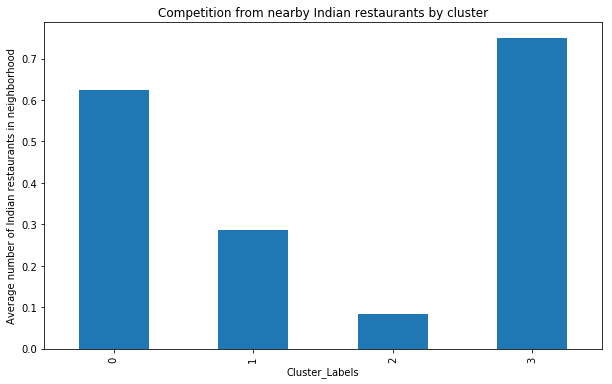

In [130]:
df_competition = toronto_pivot.loc[(0,1,2,3), 'Number_of_Indian_Restaurants']
df_competition.plot(kind='bar', figsize=(10,6))
plt.ylabel('Average number of Indian restaurants in neighborhood') # add y-label to the plot
plt.title('Competition from nearby Indian restaurants by cluster') # add title to the plot
plt.show()

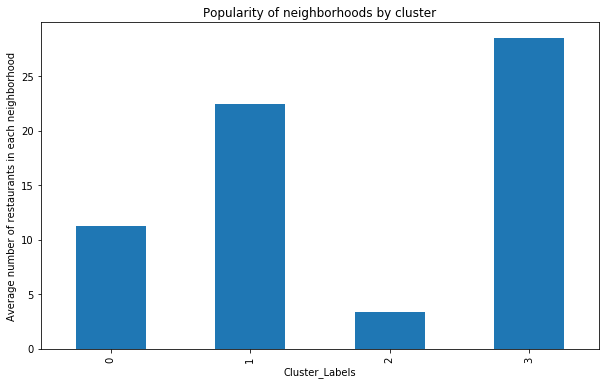

In [131]:
df_total_restaurants = toronto_pivot.loc[(0,1,2,3), 'Total_Restaurants']
df_total_restaurants.plot(kind='bar', figsize=(10,6))
plt.ylabel('Average number of restaurants in each neighborhood') # add y-label to the plot
plt.title('Popularity of neighborhoods by cluster') # add title to the plot
plt.show()

In [134]:
toronto_neighborhoods_clustering[toronto_neighborhoods_clustering['Cluster_Labels']==1]

,Total_Restaurants,Unique_Cuisines,Number_of_Indian_Restaurants,Price_Tier,Cluster_Labels,Cluster Labels
Neighborhood,,,,,,
Central Bay Street,21,16,1.0,1.904762,1,1
"Commerce Court,Victoria Hotel",25,13,0.0,2.500000,1,1
"Design Exchange,Toronto Dominion Centre",24,13,0.0,2.560000,1,1
"First Canadian Place,Underground city",24,14,0.0,2.640000,1,1
"Little Portugal,Trinity",20,14,0.0,2.100000,1,1
"Ryerson,Garden District",22,16,0.0,1.681818,1,1
Stn A PO Boxes 25 The Esplanade,21,14,1.0,2.181818,1,1
